# SQL Lab

In this lab we will learn how to use execute SQL from the ipython notebook and practice some queries on the [Northwind sample database](https://northwinddatabase.codeplex.com/) that we used in Lesson 3.1.

First of all let's install psycopg2. 

Either:

> conda install psycopg2

Or:

> pip install psycopg2

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
conn_str = "host='dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com' dbname='northwind' user='dsi_student' password='gastudents'"
conn = psycopg2.connect(conn_str)

Nice!!! We can now go ahead with the lab!

## 1: Inspect the Database

If we were connected via console, it would be easy to list all tables using `\dt`. We can however access table information performing a query on the `information_schema.tables` table.

### 1.a: List Tables

1. Write a `SELECT` statement that lists all the tables in the public schema of the `northwind` database, sorted alphabetically.

In [3]:
SQL_STRING = '''
SELECT table_schema,table_name
FROM information_schema.tables
WHERE table_schema = 'public'
ORDER BY table_name;
'''

northwind_tables = pd.read_sql(SQL_STRING, con=conn)
northwind_tables.head()

,table_schema,table_name
0,public,categories
1,public,categoriesmerged
2,public,categories_pd
3,public,credit_card_feature
4,public,customercustomerdemo


### 1.b: Print Schemas

The table `INFORMATION_SCHEMA.COLUMNS` contains schema information on each.

Query it to display schemas of all the public tables. In particular we are interested in the column names and data types. Make sure you only include public schemas to avoid cluttering your results with a bunch of postgres related stuff.

In [4]:
SQL_STRING = '''
select table_name, column_name, data_type
from INFORMATION_SCHEMA.COLUMNS
where table_catalog = 'northwind'
and table_schema = 'public';
'''

northwind_schemas = pd.read_sql(SQL_STRING, con=conn)
northwind_schemas.head()

,table_name,column_name,data_type
0,categories,CategoryID,smallint
1,categories,CategoryName,character varying
2,categories,Description,text
3,categories,Picture,bytea
4,full_order_table5,ProductID,smallint


### 1.c Table peek

Another way of quickly looking at table information is to query the first few rows. Do this for a couple of tables, for example: `orders`, `products`, `usstates`. Display only the first 3 rows.


In [5]:
SQL_STRING = 'select * from orders limit 3'

pd.read_sql(SQL_STRING, con=conn)

,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France
1,10249,TOMSP,6,1996-07-05,1996-08-16,1996-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,None,44087,Germany
2,10250,HANAR,4,1996-07-08,1996-08-05,1996-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,RJ,05454-876,Brazil


In [6]:
SQL_STRING = 'select * from products limit 3'

pd.read_sql(SQL_STRING, con=conn)

,ProductID,ProductName,SupplierID,CategoryID,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,8,1,10 boxes x 30 bags,18.0,39,0,10,1
1,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,1
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.0,13,70,25,0


In [7]:
SQL_STRING = 'select * from usstates limit 3'

pd.read_sql(SQL_STRING, con=conn)

,StateID,StateName,StateAbbr,StateRegion
0,1,Alabama,AL,south
1,2,Alaska,AK,north
2,3,Arizona,AZ,west


As you can see, some tables (like `usstates` or `region`) contain information that is probably less prone to change than other tables (like `orders` or `order_details`). This database is well organized to avoid unnecessary duplication. Let's start digging deeper in the data.

## 2: Products

What products is this company selling? The `products` and `categories` tables contain information to answer this question.

Use a combination of SQL queries and Pandas merge to answer the following questions:

- What categories of products is the company selling?
- How many products per category does the catalog contain?
- Let's focus only on products that have not been discontinued => how many products per category?
- What are the most expensive 5 products (not discontinued)?
- How many units of each of these 5 products are there in stock?
- Draw a pie chart of the categories, with slices that have the size of the number of products in that category (use non discontinued products).

### 2.a: What categories of products is the company selling?

Remember that PostgreSQL is case sensitive.

In [8]:
categories = pd.read_sql('select "CategoryID", "CategoryName", "Description" from categories;', con=conn)
categories

,CategoryID,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


### 2.b: How many products per category does the catalog contain?

Keep in mind that you can cast a %sql result to a pandas dataframe using the `.DataFrame()` method.

In [9]:
SQL_STRING='''
select "CategoryID", count(*) AS count
from  products
group by "CategoryID"
order by count desc;
'''
category_counts = pd.read_sql(SQL_STRING, con=conn)
category_counts

,CategoryID,count
0,3,13
1,8,12
2,1,12
3,2,12
4,4,10
5,5,7
6,6,6
7,7,5


In [10]:
pd.merge(category_counts, categories, on="CategoryID")

,CategoryID,count,CategoryName,Description
0,3,13,Confections,"Desserts, candies, and sweet breads"
1,8,12,Seafood,Seaweed and fish
2,1,12,Beverages,"Soft drinks, coffees, teas, beers, and ales"
3,2,12,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
4,4,10,Dairy Products,Cheeses
5,5,7,Grains/Cereals,"Breads, crackers, pasta, and cereal"
6,6,6,Meat/Poultry,Prepared meats
7,7,5,Produce,Dried fruit and bean curd


### 2.c: How many not discontinued products per category?

In [11]:
SQL_STRING='''
select "CategoryID", count(*) AS count
from  products
where "Discontinued" = 0
group by "CategoryID"
order by count desc;
'''
category_counts_not_disc = pd.read_sql(SQL_STRING, con=conn)
category_counts_not_disc

,CategoryID,count
0,3,13
1,8,12
2,2,11
3,4,10
4,1,9
5,5,6
6,7,4
7,6,2


In [12]:
products_per_category = pd.merge(category_counts_not_disc, categories, on='CategoryID')
products_per_category

,CategoryID,count,CategoryName,Description
0,3,13,Confections,"Desserts, candies, and sweet breads"
1,8,12,Seafood,Seaweed and fish
2,2,11,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
3,4,10,Dairy Products,Cheeses
4,1,9,Beverages,"Soft drinks, coffees, teas, beers, and ales"
5,5,6,Grains/Cereals,"Breads, crackers, pasta, and cereal"
6,7,4,Produce,Dried fruit and bean curd
7,6,2,Meat/Poultry,Prepared meats


### 2.d: What are the most expensive 5 products (not discontinued)?

In [13]:
SQL_STRING='''
select "ProductID", "ProductName", "UnitPrice" from products
where "Discontinued" = 0
order by "UnitPrice" desc
limit 5;
'''
pd.read_sql(SQL_STRING, con=conn)

,ProductID,ProductName,UnitPrice
0,38,Côte de Blaye,263.5
1,20,Sir Rodney's Marmalade,81.0
2,18,Carnarvon Tigers,62.5
3,59,Raclette Courdavault,55.0
4,51,Manjimup Dried Apples,53.0


### 2.e: How many units of each of these 5 products are there in stock?

In [14]:
SQL_STRING='''
select "ProductID", "ProductName", "UnitsInStock" from products
where "Discontinued" = 0
order by "UnitPrice" desc
limit 5;
'''
pd.read_sql(SQL_STRING, con=conn)

,ProductID,ProductName,UnitsInStock
0,38,Côte de Blaye,17
1,20,Sir Rodney's Marmalade,40
2,18,Carnarvon Tigers,42
3,59,Raclette Courdavault,79
4,51,Manjimup Dried Apples,20


### 2.f: Pie Chart

Use pandas to make a pie chart plot.

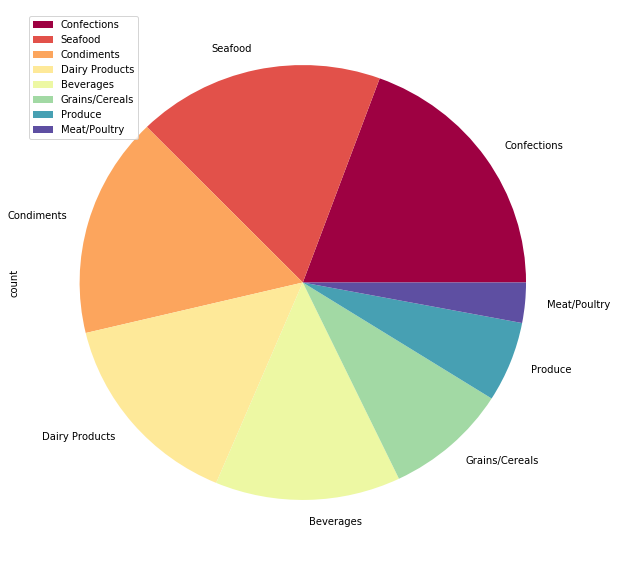

In [15]:
products_per_category[['CategoryName', 'count']]\
            .set_index('CategoryName').plot(kind = 'pie',\
                                            y = 'count',\
                                            figsize = (10,10),\
                                            colormap = 'Spectral')
plt.legend(loc = 2)

## 3: Orders

Now that we have a better understanding of products, let's start digging into orders.

- How many orders in total?
- How many orders per year
- How many orders per quarter
- Which country is receiving the most orders
- Which country is receiving the least
- What's the average shipping time (ShippedDate - OrderDate)
- What customer is submitting the highest number of orders?
- What customer is generating the highest revenue (need to pd.merge with order_details)
- What fraction of the revenue is generated by the top 5 customers?

In [16]:
pd.read_sql('select * from orders limit 3;', con=conn)

,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France
1,10249,TOMSP,6,1996-07-05,1996-08-16,1996-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,None,44087,Germany
2,10250,HANAR,4,1996-07-08,1996-08-05,1996-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,RJ,05454-876,Brazil


### 3.a: How many orders in total?

In [17]:
pd.read_sql('select count(*) from orders;', con=conn)

,count
0,830


### 3.b: How many orders per year?

In [18]:
order_dates = pd.read_sql('select "OrderID", "OrderDate" from orders;', con=conn)
order_dates.index = pd.to_datetime(order_dates['OrderDate'])
order_dates.head()

,OrderID,OrderDate
OrderDate,,
1996-07-04,10248,1996-07-04
1996-07-05,10249,1996-07-05
1996-07-08,10250,1996-07-08
1996-07-08,10251,1996-07-08
1996-07-09,10252,1996-07-09


In [19]:
orders_per_year = order_dates.groupby(pd.Grouper(freq='Y'))['OrderID'].count()
orders_per_year

OrderDate
1996-12-31    152
1997-12-31    408
1998-12-31    270
Freq: A-DEC, Name: OrderID, dtype: int64

### 3.c: How many orders per quarter?

Make a line plot for these.

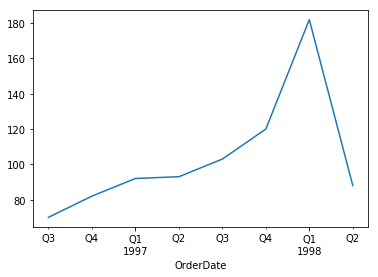

In [20]:
orders_per_quarter = order_dates.groupby(pd.Grouper(freq='Q'))['OrderID'].count()
orders_per_quarter.plot()

### 3.d: Which country is receiving the most orders?

In [21]:
SQL_STRING='''
select "ShipCountry", count(*) as count
from orders
group by "ShipCountry"
order by count desc
limit 3;
'''
pd.read_sql(SQL_STRING, con=conn)

,ShipCountry,count
0,Germany,122
1,USA,122
2,Brazil,83


### 3.e: Which country is receiving the least?

In [22]:
SQL_STRING='''
select "ShipCountry", count(*) as count
from orders
group by "ShipCountry"
order by count
limit 3;
'''
pd.read_sql(SQL_STRING, con=conn)

,ShipCountry,count
0,Norway,6
1,Poland,7
2,Portugal,13


### 3.f: What's the average shipping time (ShippedDate - OrderDate)?

In [23]:
#In 2 steps
SQL_STRING='''
select 
    "ShippedDate", 
    "OrderDate", 
    "ShippedDate" - "OrderDate" as daysdiff 
from orders;
'''
days_diff = pd.read_sql(SQL_STRING, con=conn)
days_diff['daysdiff'].mean()

8.491965389369591

In [24]:
# in 1 query:
pd.read_sql('select avg("ShippedDate" - "OrderDate") from orders;', con=conn)

,avg
0,8.491965


### 3.g: What customer is submitting the highest number of orders?

In [25]:
#In 2 steps
SQL_STRING='''
select 
    "CustomerID", 
    count(*) as count 
from orders 
group by "CustomerID" 
limit 3 ;
'''
pd.read_sql(SQL_STRING, con=conn)

,CustomerID,count
0,HUNGO,19
1,VAFFE,11
2,PRINI,5


### 3.h: What customer is generating the highest revenue (need to pd.merge with order_details)?

In [26]:
customer_orders = pd.read_sql('select "CustomerID", "OrderID" from orders;', con=conn)
order_details =  pd.read_sql('select * from order_details', con=conn)
customer_order_details = pd.merge(customer_orders, order_details)
customer_order_details.head()

,CustomerID,OrderID,ProductID,UnitPrice,Quantity,Discount
0,VINET,10248,11,14.0,12,0.0
1,VINET,10248,42,9.8,10,0.0
2,VINET,10248,72,34.8,5,0.0
3,TOMSP,10249,14,18.6,9,0.0
4,TOMSP,10249,51,42.4,40,0.0


In [27]:
customer_order_details['OrderRevenue'] = customer_order_details['UnitPrice'] * \
                                         customer_order_details['Quantity'] * \
                                         (1.0 - customer_order_details['Discount'])

In [28]:
customer_revenue = customer_order_details.groupby('CustomerID')['OrderRevenue'].sum().sort_values(ascending = False)
customer_revenue.head()

CustomerID
QUICK    110277.3050
ERNSH    104874.9785
SAVEA    104361.9500
RATTC     51097.8005
HUNGO     49979.9050
Name: OrderRevenue, dtype: float64

### 3.i: What fraction of the revenue is generated by the top 5 customers?

Compare that with the fraction represented by 5 customers over the total number of customers.

In [29]:
customer_revenue.head().sum() / customer_revenue.sum()

0.33227543988244534

In [30]:
5.0 / customer_revenue.count()

0.056179775280898875